# **Time Series Analysis and Prediction of Bicycle Counts on Seattle's Fremont Bridge**

## Introduction

In this project, I want to explore time series and prediction using bicycle traffic data collected from Seattle's Fremont Bridge. The dataset includes hourly bicycle counts on the west and east sidewalks of the bridge, spanning multiple years. The goal is to analyze the trends, patterns, and seasonality in the data and build predictive models to forecast future bicycle counts. <br />

I will employs various methods for exploratory data analysis and visualization, including rolling averages and time-based groupings (daily, weekly, trends). Also, two predictive modeling approaches wll be implemented:
* **Linear Regression**: Incorporates lag features and time-based predictors to forecast bicycle counts.
* **LSTM and Random Forest**: Advanced time series forecasting models to predict future traffic patterns.

This analysis is useful for urban planning, traffic management, and understanding the usage of pedestrian and bicycle infrastructure in cities.

## What's Forecasting?

In the actual world, forecasting is arguably the most prevalent use of machine learning. Governments predict population and economic growth, businesses predict product demand, and meteorologists predict the weather. In science, government, and industry (not to mention our personal lives!), there is a critical need to grasp what lies ahead. To meet this requirement, practitioners in these domains are increasingly using machine learning. <br />

Time series forecasting has a long history and is a vast field. In order to get the most accurate forecasts, this course focuses on applying contemporary machine learning techniques to time series data. The concepts in this course will be useful whenever precise forecasts are a top concern, but they were inspired by winning solutions from previous Kaggle forecasting contests.

## What's a Time Series?

The time series, which is a collection of data made across time, is the basic object of forecasting. The observations are usually recorded at a regular interval, such as daily or monthly, in forecasting applications.

#### Importing Libraries

In the following cell, I will import **pandas** for data manipulation and analysis, **matplotlip** for creating visualizations, **seaborn** for enhanced visualizations with better aesthetics, and finally **numpy** for numerical operations and arrays manipulations.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Loading and Preprocessing the Dataset

We will read the dataset from q CSV file using the **read_csv()** function from pandas, and set the **Date** column as the index, which is crucial for time series operations. Also, setting the **parse_dates=True** automatically converts the **Date** column to **datetime** objects for easier date-time manipulations.

In [4]:
data = pd.read_csv("fremont-bridge.csv", index_col='Date', parse_dates=True)
data.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


#### Cleaning and Enhancing the Data

Let's aggregate the counts from West and East sidewalks and call the new created column 'Total'. Then we can ensure  that our data is clean by removing rows containing **NaN**.

In [5]:
data["Total"] = data["West"] + data["East"]

data = data.dropna()
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


#### Summarizing the Data

To summarize the data we can use **data.describe()** which provides summary statistics (mean, min, max, etc.) for numeric columns.

In [6]:
data.describe()

,West,East,Total
count,45976.000000,45976.000000,45976.000000
mean,54.712306,55.479315,110.191622
std,72.935797,80.232055,139.189603
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,60.000000
75%,72.000000,68.000000,144.000000
max,854.000000,717.000000,1165.000000


#### Ploting Total Bicycle Counts

Let's plot the 'Total' column over time.

Text(0, 0.5, 'Hourly Bicycle Count')

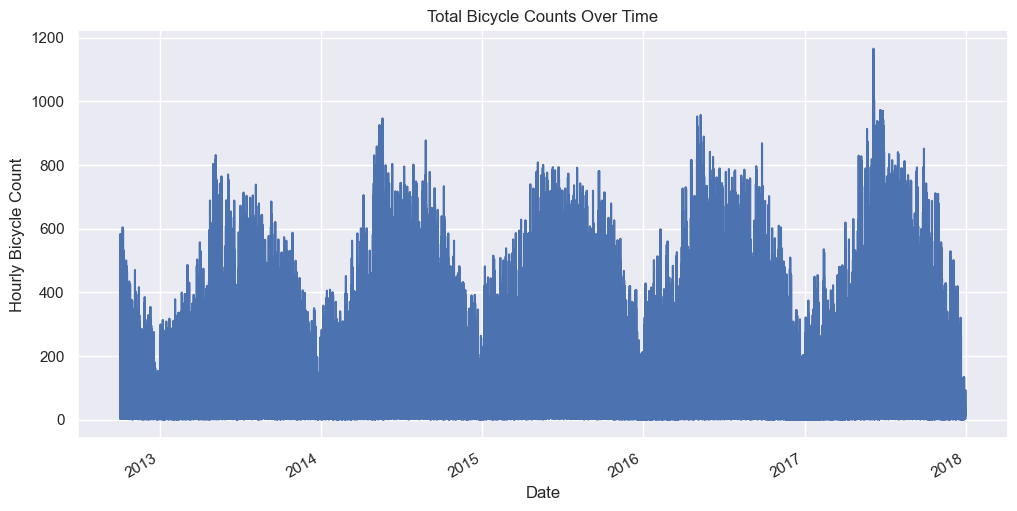

In [7]:
sns.set()
data["Total"].plot(figsize=(12, 6), title="Total Bicycle Counts Over Time")
plt.ylabel("Hourly Bicycle Count")

#### Analyzing Weekly Trends

To analyze weekly trends we need to aggregate data weekly (sum daily counts into weekly totals). We can do that using **resample('W').sum()**. Then, we can visualize those weekly trends to identify seasonability or growth patterns.

Text(0, 0.5, 'Total Weekly Count')

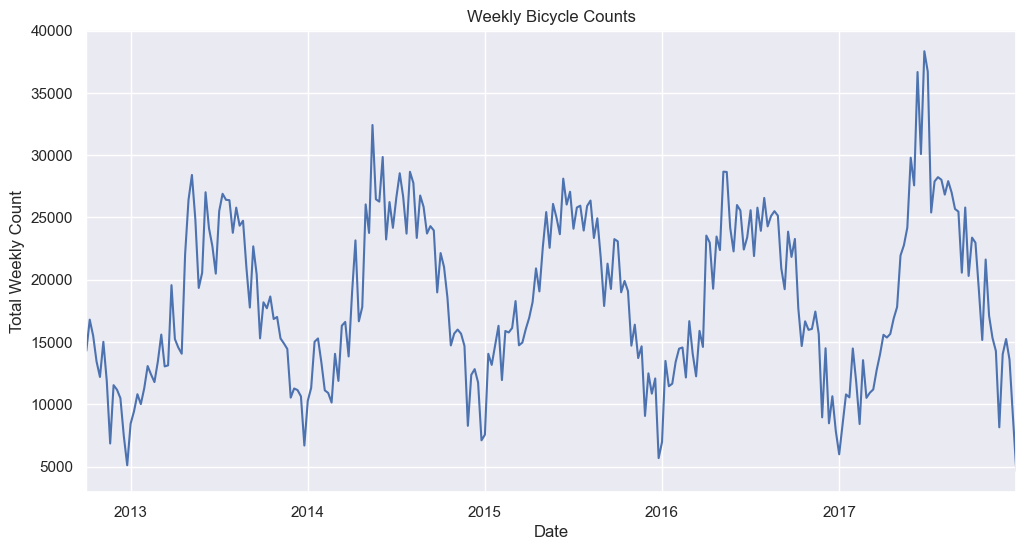

In [8]:
weekly = data['Total'].resample('W').sum()
weekly.plot(figsize=(12, 6), title="Weekly Bicycle Counts", style='-')
plt.ylabel("Total Weekly Count")

#### Analyzing Daily Trends with Rolling Averages

To analyze daily trends with rolling averages, we need to aggregate data in daily totals, using **resample('D').sum()**, and compute a centered 30-day rolling mean to smooth short-term fluctuations, using **rolling(30, center=True).mean()**.

Text(0, 0.5, 'Total Daily Count')

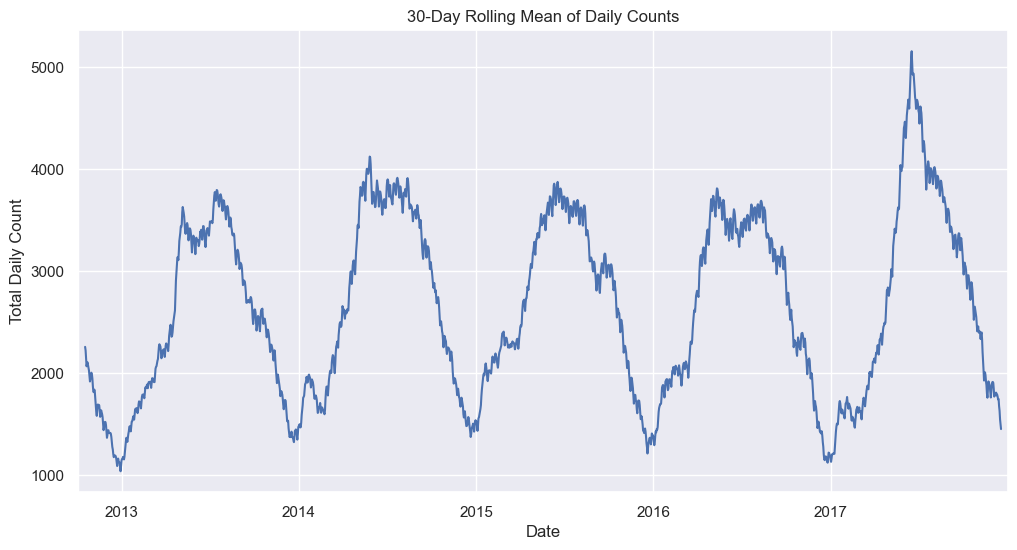

In [9]:
daily = data['Total'].resample('D').sum()
daily.rolling(30, center=True).mean().plot(figsize=(12, 6), title="30-Day Rolling Mean of Daily Counts")
plt.ylabel("Total Daily Count")

#### Adding Time-Related Features

Let's extract compenents of the datetime index (hour, day, etc.) to use as features for predictive models

In [10]:
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['DayOfWeek'] = data.index.dayofweek

#### Creating Lag Features

In this section, I would like to tell you about Time Series features. There are two kinds of features unique to time series: **time-step features** and **lag features**. 
* We can obtain time-step features straight from the time index. The most basic time-step feature is the 'time dummy', which counts off time steps in the series from beginning to end.
Time-step features let you model time dependence. A series is time dependent if its values can be predicted from the time they occured.

* To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.
Lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.


Here we will create a new feature that represents the previous day's total count (lag feature). Also, we need to drop  rows with missing lag values to ensure complete data for modeling.

In [11]:
data['Lag1'] = data['Total'].shift(1)
data = data.dropna()
data.head()

,West,East,Total,Hour,Day,Month,Year,DayOfWeek,Lag1
Date,,,,,,,,,
2012-10-03 01:00:00,4.0,6.0,10.0,1,3,10,2012,2,13.0
2012-10-03 02:00:00,1.0,1.0,2.0,2,3,10,2012,2,10.0
2012-10-03 03:00:00,2.0,3.0,5.0,3,3,10,2012,2,2.0
2012-10-03 04:00:00,6.0,1.0,7.0,4,3,10,2012,2,5.0
2012-10-03 05:00:00,21.0,10.0,31.0,5,3,10,2012,2,7.0


#### Defining Features and Targets

In the following cell, I will split data into features 'X' (including lagged data and time-related features), and target 'y' (the 'Total' column, which we aim to predict). <br />

Then, I will split the data into training and testing sets based on a specified date (2016-01-01).

In [12]:
features = ['Lag1', 'DayOfWeek', 'Hour', 'Month']
X = data[features]
y = data['Total']

split_date = '2016-01-01'
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

#### Linear Regression Modeling

Now, let's implement a linear regression algorithm on our data and evaluate the results

RMSE: 95.6672081101714


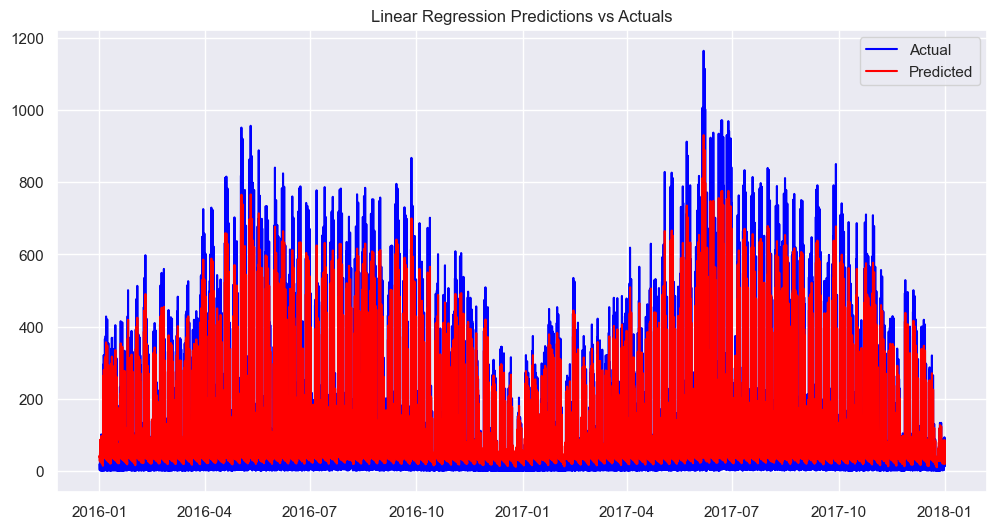

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Plot predictions vs. actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title("Linear Regression Predictions vs Actuals")
plt.legend()

As we see, the curves of actuals and predictions are intertwined, so let's better implement that on weekly trends to get a clear insight of how our model performed compared to actual data. 

Weekly Prediction RMSE: 3499.4549486723386


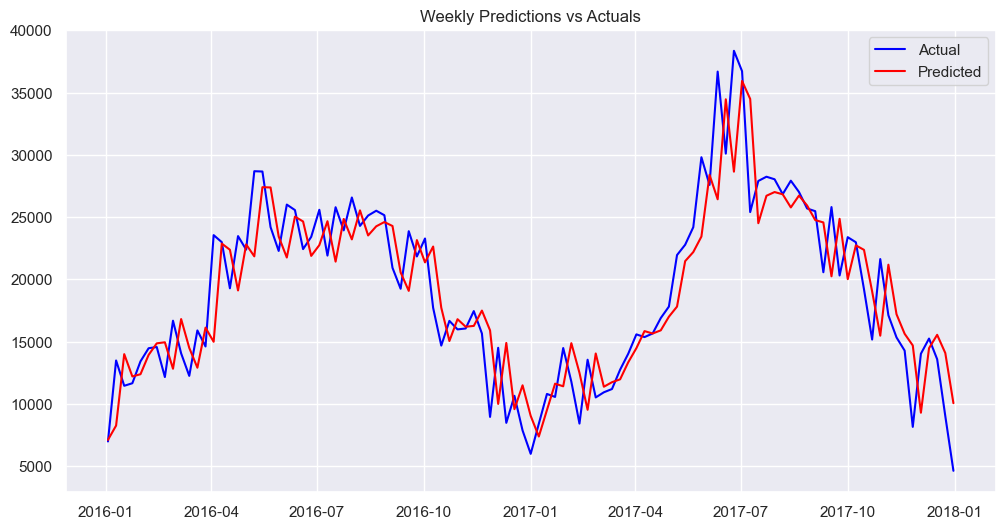

In [14]:
# Create lag features using the previous weekly resampled data
weekly_data = pd.DataFrame(weekly)
weekly_data['Lag1'] = weekly_data['Total'].shift(1)

# Drop rows with missing lag values
weekly_data = weekly_data.dropna()
# Split the data into training and testing sets
split_date = '2016-01-01'
train = weekly_data[weekly_data.index < split_date]
test = weekly_data[weekly_data.index >= split_date]

# Define the features and target
X_train = train[['Lag1']]
y_train = train['Total']
X_test = test[['Lag1']]
y_test = test['Total']

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Weekly Prediction RMSE: {rmse}")

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred, label='Predicted', color='red')
plt.title("Weekly Predictions vs Actuals")
plt.legend()

#### Random Forest Regression

Random Forest is a tree-based ensemble algorithm that can model non-linear relationships and is well-suited for time series when features are engineered correctly.

Random Forest RMSE: 4015.5059510174474


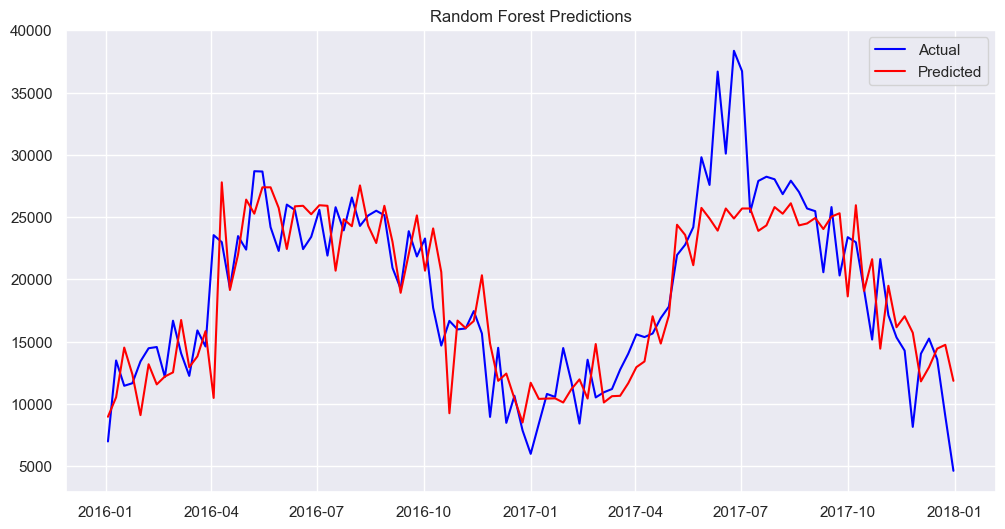

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

weekly_data = pd.DataFrame(weekly)
weekly_data['Lag1'] = weekly_data['Total'].shift(1)

# Drop rows with missing lag values
weekly_data = weekly_data.dropna()
# Split the data into training and testing sets
split_date = '2016-01-01'
train = weekly_data[weekly_data.index < split_date]
test = weekly_data[weekly_data.index >= split_date]

# Define the features and target
X_train = train[['Lag1']]
y_train = train['Total']
X_test = test[['Lag1']]
y_test = test['Total']


# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title("Random Forest Predictions")
plt.show()

#### Long Short-Term Memory (LSTM) Neural Network

LSTMs are well-suited for sequential data like time series. However, they require the data to be structured in sequences.

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1588
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0827 
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0391 
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 16

Text(0.5, 1.0, 'LSTM Predictions')

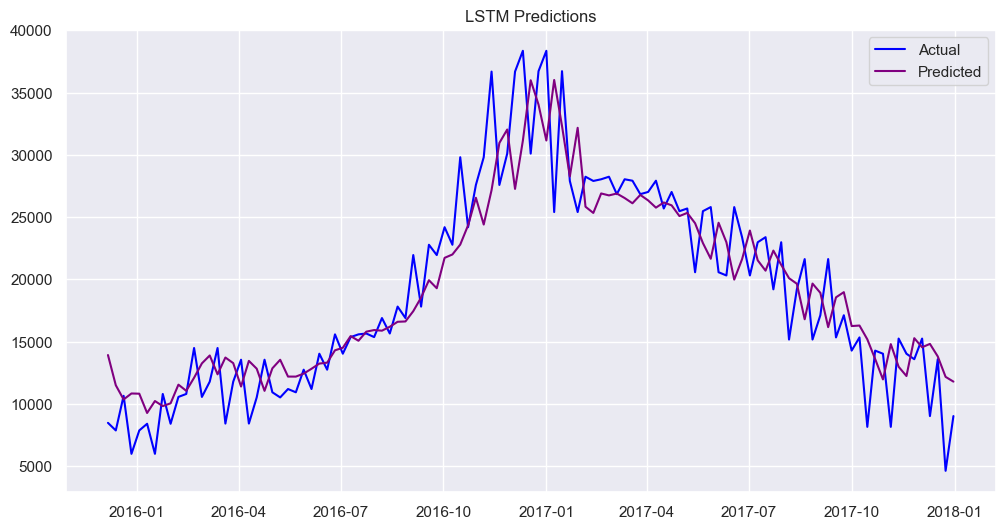

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_data.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 2  # Number of days to use for prediction
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential([
    Input(shape=(10, 1)),  # Define the input shape explicitly
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Rescale actuals
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_lstm))
print(f"LSTM RMSE: {rmse_lstm}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index[-len(y_test):], y_test_rescaled, label='Actual', color='blue')
plt.plot(weekly_data.index[-len(y_test):], y_pred_lstm, label='Predicted', color='purple')
plt.legend()
plt.title("LSTM Predictions")

## Conclusion

In general, the use of time series analysis and forecasting to actual data -specially, bicycle traffic on Seattle's Fremont Bridge- is demonstrated in this project. We discovered daily and weekly patterns, long-term trends, and other seasonal variations by utilizing extensive visualizations and a variety of predictive models. <br />

The models explored—Linear Regression, Random Forest, and LSTM—demonstrated varying strengths in forecasting. While Linear Regression offered simplicity and interpretability, Random Forest excelled at capturing non-linear relationships. LSTM showcased its potential for handling sequential data, effectively modeling complex temporal patterns. <br />

These predictive insights can assist urban planners in optimizing infrastructure, managing traffic flow, and improving public transportation systems. This project serves as a practical example of integrating machine learning models with time series data, laying the groundwork for more advanced implementations or the incorporation of additional data sources for deeper exploration.